# Predicting Amazon review ratings based only on the text using TF-IDF and Logistic Regression
 
In this exercise I will use a simple Logistic Regression model to explore if we can predict the rating of a Book review in Amazon based exclusively on the text of the review.
 
I will begin importing the libraries necessary to perform this exercise.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient

import re

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

client = MongoClient()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ordovas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ordovas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/ordovas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Now we load a fraction of the dataset and visualize the head of the dataset that we obtained.

In [2]:
db = client.get_database("amazon")
# Define an alias for the books dataset
books =db.books
# Obtain a random sample from the dataset, selecting only a few records 
# (we will use only overall and reviewTest, but I will load a few more just in case I
# want to play with more info...)
res = list(books.aggregate([
    { "$sample": { "size": 75000 }}
    ,{ "$project": {"id": "$_id", "_id": 0, "overall": 1, "reviewText": 1,"summary":1,"reviewerName":1}} 
]))
# Converting to pandas DataFrame
df=pd.DataFrame(res)

In [3]:
df.head()

,overall,reviewerName,reviewText,summary,id
0,2,Lauren Page,This book was just horrid. I found myself just...,Nothing like the other books. Just bad.,6033ab76f7ccad4a92f27666
1,2,Taka,"In the first twenty or thirty pages, I was ple...",OVERrated,6033ab85f7ccad4a92f55229
2,5,Samuel J.,"Obviously the story is a classic for a reason,...",Very Nice,6033ab79f7ccad4a92f30a94
3,5,Mary M. Anderson,I wish I had seen this book when I was first b...,Best Book Ever,6033ab7df7ccad4a92f3c7df
4,5,DiElizabeth,"This is a must read book , especially before w...",Magical adventure,6033ab79f7ccad4a92f307e5


I wil now drop the rows with NaN values in the `reviewText` column.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   overall       75000 non-null  int64 
 1   reviewerName  75000 non-null  object
 2   reviewText    74989 non-null  object
 3   summary       74989 non-null  object
 4   id            75000 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.9+ MB


In [5]:
df=df.dropna(subset=['reviewText'])

Let's check that everything is fine...

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74989 entries, 0 to 74999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   overall       74989 non-null  int64 
 1   reviewerName  74989 non-null  object
 2   reviewText    74989 non-null  object
 3   summary       74978 non-null  object
 4   id            74989 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


OK, so now I will examine the `overall` column, that is the target feature.
 
There are far more reviews with high ratings than with low scores, so there is no balance. To solve this, later on I will weight the clases instead of selecting now the exact number of reviews for each rating.

In [7]:
df["overall"].value_counts()

5    47257
4    15151
3     6715
2     3152
1     2714
Name: overall, dtype: int64

## Preprocessing: Cleaning text and TF-IDF vectorization
 
 
To begin with I will clean the review text ignoring stop words and lemmatizing all the words.

In [10]:
# Function to lemmatize the text of the review
def lemmatizer_text(text):
    # Load Lemmatizer
    lemmatizer=WordNetLemmatizer()
    # Obtain a list with each word
    words = nltk.word_tokenize(text)
    # Returns an string joining the lemmatized words
    return ' '.join([lemmatizer.lemmatize(w) for w in words])


def cleaning_review(texts):
    #Remove numbers, punctuation and lowercase everything
    res=re.sub("[^A-Za-z]+", " ", texts.lower()) 
    #Lemmanize the text of the review
    res=lemmatizer_text(res)
    #Remove words with less than 4 letters
    res=re.sub(r'\b\w{1,3}\b', "", res) 
    #Remove rest of stop words
    for stopword in stopwords.words('english'): 
        sw=stopword.replace("'","")
        res=res.replace(f" {sw} "," ")
    return res


Now I will create a feature with the "cleaned" text named `review_clean`

In [11]:
df["review_clean"]=df["reviewText"]
df["review_clean"]=df["review_clean"].apply(cleaning_review)
df=df.reset_index()

And then we can now create the TF-IDF vectors for each review using `TfidfVectorizer` from  `sklearn`. We ignore words that don't appear in at least 5 reviews.

But first, we need to split the dataset into train and test samples. I will choose 85% of the sample to train and 15% to test. The TF-IDF vectorizer needs to be trained first on the train dataset and after that applied to the test dataset. This is done in order to prevent data leakage, that means that information outside of the train dataset is used during the trainin phase. The TF-IDF vectorizer is applied to the test dataset *after* it is trained with the train dataset.

In [12]:
Xraw_train, Xraw_test, y_train, y_test = train_test_split(df["review_clean"], df["overall"], test_size=0.15, random_state=42)

v = TfidfVectorizer(min_df=5)
tf_idf_train = v.fit_transform(Xraw_train).toarray()
tf_idf_test = v.transform(Xraw_test).toarray()

X_train=pd.DataFrame(tf_idf_train, columns=v.get_feature_names())
X_test=pd.DataFrame(tf_idf_test, columns=v.get_feature_names())

Just for curiosity, let's check how many features/words the TF-IDF vectors have...

In [13]:
len(v.get_feature_names())

20476

And let's check the size of the train and test datasets.

In [14]:
len(y_train),len(y_test)

(63740, 11249)

## Logistic Regression: Predicting the scores based on the TF-IDF vectors

Now it's time to use the Logistic Regression model to predict the scores of the reviews. The TD-IFD vectors are the features used to predict the target, that is the `overall` column that stores the numeric ratings.
 
We will activate `class_weight="balanced"`, as the classes (scores) are not balanced, so if we do not weigh the classes the fit will be biased towards high ratings (most populated classes).
 
This is just a very simple approach, without fine tuning anything. This is just an exercise for learning purposes.

In [15]:
clf = LogisticRegression(random_state=0,class_weight="balanced").fit(X_train, y_train)

/home/ordovas/anaconda3/envs/ironhack/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


That's it? Well, now we need to check the performance of this model...

Let's check the score of the classification model for the train and test samples

In [16]:
sc_train=clf.score(X_train, y_train)
sc_test=clf.score(X_test, y_test)
print(f"Train sample classification score: {round(sc_train,2)}")
print(f"Test sample classification score: {round(sc_test,2)}")

Train sample classification score: 0.68
Test sample classification score: 0.57


This seems just OK, but let's check an histogram to see the accuracy of the predictions by plotting the true score minus the predicted score.

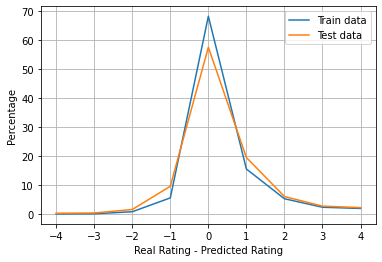

In [17]:
counts, bins = np.histogram(y_train-clf.predict(X_train),bins=np.arange(-4,6))
plt.plot(bins[:-1],counts*100/sum(counts),label="Train data")
plt.grid()
counts, bins = np.histogram(y_test-clf.predict(X_test),bins=np.arange(-4,6))
plt.plot(bins[:-1],counts*100/sum(counts),label="Test data")
plt.xlabel("Real Rating - Predicted Rating")
plt.ylabel("Percentage")
plt.legend();

Well, this simple model seems not to be very wrong! Let's quantify this with the confusion matrices as well.

In [18]:
confusion_matrix(y_train,clf.predict(X_train))

array([[ 2082,   109,    45,    23,    53],
       [  139,  2306,   143,    56,    55],
       [  331,   555,  3738,   626,   430],
       [  395,   596,  1708,  7495,  2690],
       [ 1250,  1123,  2456,  7509, 27827]])

In [19]:
confusion_matrix(y_test,clf.predict(X_test))

array([[ 195,  114,   40,   18,   35],
       [ 114,  180,   96,   36,   27],
       [ 101,  198,  412,  220,  104],
       [  88,  138,  434,  957,  650],
       [ 253,  223,  444, 1449, 4723]])

And normalized to the true scores.

Train subsample:


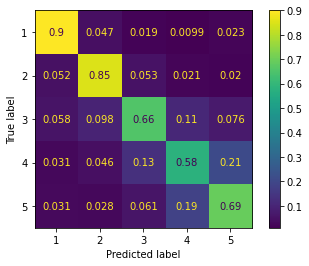

Test subsample:


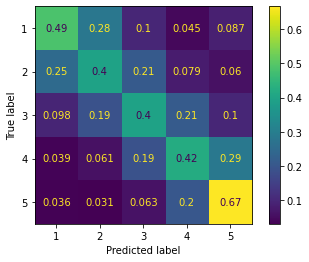

In [20]:
print("Train subsample:")
plot_confusion_matrix(clf, X_train, y_train,cmap="viridis",normalize="true") 
plt.show();
print("Test subsample:")
plot_confusion_matrix(clf, X_test, y_test,cmap="viridis",normalize="true")
plt.show();

The diagonal indicates that the Logistic Model predicts reasonably well the score of the review for this simple approach.

## Undersanding the Logistic Regression: How it is pedicted

I will create a DataFrame with the coefficients of each score to understand how the features (words) contributes to each class.

In [21]:
model=pd.DataFrame(clf.coef_,columns=X_train.columns)
model=model.T
model.columns=["1","2","3","4","5"]
model.head(20)

,1,2,3,4,5
aaron,-0.061693,0.192707,-0.142920,-0.162202,0.174108
aback,-0.181668,0.242306,-0.086103,-0.003963,0.029428
abandon,0.897491,-0.205578,-0.376557,-0.203174,-0.112182
abandoned,0.836370,-0.211472,-0.313179,0.016732,-0.328450
abandoning,0.149999,-0.252986,-0.019347,0.093836,0.028497
abandonment,0.057166,0.039397,0.150065,-0.095506,-0.151121
abarat,-0.578782,0.478916,-0.028714,-0.121703,0.250284
abbey,-0.394625,0.721646,-0.037053,-0.662660,0.372692
abbot,-0.078685,0.149829,-0.064281,0.049720,-0.056583
abbott,-0.260464,0.379576,0.055833,0.048523,-0.223469


For the highest score, the words that are directly correlated and contributes the most are words as "excellent", "great", "love", "fantastic", "amazing"...

In [22]:
model["5"].sort_values(ascending=False).head(20)

excellent      4.601775
wonderful      4.093400
amazing        3.805142
highly         3.804939
love           3.625317
loved          3.539603
perfect        3.433680
fantastic      3.384947
beautiful      3.282861
beautifully    3.177139
awesome        3.147184
great          3.030050
today          3.019786
provoking      2.910257
terrific       2.890560
thank          2.855471
wait           2.746846
masterpiece    2.656303
outstanding    2.606295
powerful       2.586116
Name: 5, dtype: float64

So, for the lowest score, it is not strange that the words that are directly correlated and contribute the most are words such as "terrible","trash" or "boring".

In [23]:
model["1"].sort_values(ascending=False).head(20)

waste             6.413316
wasted            5.712731
worst             5.666858
disappointment    4.118679
terrible          4.072798
boring            4.052279
poorly            3.826763
hated             3.715275
stupid            3.712801
nonsense          3.654662
trash             3.597680
amazon            3.431366
zero              3.413424
garbage           3.410193
horrible          3.402571
crap              3.393276
junk              3.380922
rubbish           3.298719
porn              3.290351
apparently        3.265722
Name: 1, dtype: float64

With respect to the intermediate scores, the words that define these reviews are related to texts that show good and bad aspects of the product, so words like "however" or "unfortunately" are weighted high, as well as "okay","somewhat" and "alright".

In [24]:
model["3"].sort_values(ascending=False).head(20)

however         3.674379
okay            3.387344
frustrating     2.719719
overall         2.685825
three           2.355088
turner          2.252566
decent          2.237369
seemed          2.171566
blown           2.124443
felt            2.119106
alright         2.041549
still           2.032812
setting         1.976933
particularly    1.973048
average         1.972463
unusual         1.950792
fairly          1.939594
lacking         1.922384
pleasant        1.914850
prefer          1.909206
Name: 3, dtype: float64

On the other side, words with the lowest value of the coefficients show other information: features that are least likely to appear on a review. For instance, for the best reviewed books, we will not find words as "boring" or "disappointing".

In [25]:
model["5"].sort_values(ascending=True).head(20)

disappointing    -5.261526
boring           -5.004400
unfortunately    -4.079230
however          -3.951741
tedious          -3.859695
instead          -3.620947
disappointed     -3.578610
waste            -3.477536
disappointment   -3.290387
okay             -3.273860
slow             -3.200287
seemed           -3.158649
predictable      -3.127049
poorly           -3.116196
depressing       -3.054896
annoying         -2.966359
premise          -2.946118
confusing        -2.853311
would            -2.812168
difficult        -2.782072
Name: 5, dtype: float64

For the products with lowest score, we will not find "perfect", "good", "enjoyed" or "great".

In [26]:
model["1"].sort_values(ascending=True).head(20)

easy           -4.638756
beautiful      -3.589769
particularly   -3.404560
enjoyed        -3.359470
excellent      -3.342778
turner         -3.303818
perspective    -3.113625
today          -3.100802
fascinating    -3.099424
still          -2.954108
especially     -2.874138
expect         -2.832547
though         -2.802692
perfect        -2.787033
awesome        -2.723490
next           -2.723467
second         -2.653393
unusual        -2.644315
love           -2.643522
easier         -2.522630
Name: 1, dtype: float64

Lastly, for scores as 3, we will not find words that indicate extreme (good or bad) reviews. 

In [27]:
model["3"].sort_values(ascending=True).head(20)

wasted       -2.384733
recommend    -2.159904
power        -2.057191
right        -2.018770
describe     -2.014200
barely       -2.010569
wait         -1.998578
thank        -1.941785
daily        -1.924913
shame        -1.917508
save         -1.889566
painful      -1.881169
scientific   -1.848593
drivel       -1.843792
study        -1.828461
loved        -1.824597
extremely    -1.824438
grader       -1.786883
pull         -1.780412
pointless    -1.745263
Name: 3, dtype: float64

## Caveats

This is a very simple approach to understand this exercise, so we can improve it a lot. We can reduce the dimensionality of the features, test different algorithms and tune the ML parameters. But in this notebook I show this simple solution to learn how it works.